In [19]:
import json as json
import pprint as pp
from operator import itemgetter

All submissions < 4 seconds are bogus since the attack starts at 5

In [20]:
all_submissions=[]
no_time=[]
results=[]
fast_submit=[]

#compares two networks by node names
def compare_net(nt1, nt2):
    if len(nt1) != len(nt2):
        names_1=set([n['name'] for n in nt1])
        return [n for n in nt2 if n['name'] not in names_1]
    else: 
        return []

#(get the submissions)
with open("_scenario.log") as f:
    count = 0
    for line in f:
        j = json.loads(line)
        all_submissions.append(j)

#(we used two completely different networks let's mark them)  
for s in all_submissions:
        if compare_net(s['network'], all_submissions[1]['network']) == []:
            s['net_type'] = 1
        elif compare_net(s['network'], all_submissions[-1]['network']) == []: 
            s['net_type'] = 2
        else: 
            print("fail")
        
for s in all_submissions:
        if "time" not in s.keys(): #no time data
            no_time.append(s)
            continue
        if s['time'] < 5:  #submitted after countdown
            fast_submit.append(s)
            continue
        if s['time'] >= 5:  #positive results
            results.append(s)
            continue

results = sorted(results, key=itemgetter('revenue'), reverse=True) #sort results based on revenue
            
print("Total:", len(all_submissions))
print("No time attribute:",len(no_time))
print("Extremely fast submissions (before attack start):", len(fast_submit))
print("Results:", len(results))

Total: 27
No time attribute: 8
Extremely fast submissions (before attack start): 10
Results: 9


In [21]:
for j in results:
    print(j['session'], end=' ')
    print("scenario: " + str(j['scenario']), end=' ')
    print("net: " + str(j['net_type']), end=' ')
    print("time: " + str(j['time']), end=' ')
    print("revenue: " + str(j['revenue']))

6f1e0e7a690aae61b6951c619a3edaa5 scenario: 0 net: 2 time: 125.203421394 revenue: 235.896702
b27d8a149e5e65f62120986cf530fe7d scenario: 0 net: 1 time: 294.315066369 revenue: 219.00990249999995
8c5df4821f8832d1ed098af684103ee4 scenario: 0 net: 1 time: 510.287879761 revenue: 215.739099
c5394fb4721a86ac4fa4e357b995a862 scenario: 0 net: 2 time: 244.789059275 revenue: 212.432524
d16e6a331d45d3803c9d2d55720d5c7f scenario: 0 net: 1 time: 155.99804911 revenue: 200.31256574999998
674f31346b837d5339ab85fd5ea022f5 scenario: 0 net: 1 time: 105.871740727 revenue: 189.23741875000002
cc7232bc04acce9d3ee09e6eaaf97c28 scenario: 0 net: 1 time: 32.001768686 revenue: 151.02343815
728e9e46d639ccbdd66762f1c299a2a3 scenario: 0 net: 2 time: 244.64599495 revenue: 140.49889124999999
3bf208d7ec1e6edbb67961fd7f5a7e3a scenario: 0 net: 1 time: 184.192718461 revenue: 78.575032


We have only 12 valid results that recorded the runtime.

Now we compare the results with the base topologies and see what has changed:

In [22]:
base1=fast_submit[2]
base2=fast_submit[-4]

def compare_ifaces(interfaces_1, interfaces_2, key="name"):
    """Compares interfaces for <key> and reports amount of changes"""
    i1 = {item['name']:item for item in interfaces_1}
    i2 = {item['name']:item for item in interfaces_2}
    change_count=0
    key2=''
    if key == 'rateup' or key == 'ratedown':
        key2 = key
        key = 'rate'
    for k, v in i2.items():
        if key not in i1[k].keys(): #some key not in source topology
            i1[k][key] = ''
        if key not in v.keys(): #some key not in dest topology
            v[key] = ''
        if key == 'rate':
            #ugly but it works ;)
            if key2 =='rateup':
                if int(v[key][:-4]) < int(i1[k][key][:-4]):
                    change_count +=1 
                continue
            if key2 =='ratedown':
                if int(v[key][:-4]) > int(i1[k][key][:-4]):
                    change_count += 1 
                continue
        if v[key] != i1[k][key]: 
            change_count += 1 
            continue
    return change_count
    
def compare_nodes(node_1, node_2, key="name"):
    """Compares interfaces of nodes for <key> and reports amount of changes"""
    n1 = {item['name']:item for item in node_1}
    n2 = {item['name']:item for item in node_2}
    change_count=0
    for k, v in n1.items():
        c = compare_ifaces(v['ifaces'], n2[k]['ifaces'], key)
        change_count += c
    return change_count

def compare_results(result):
    """Compares results of type <net_type> with its base topology and stores changes"""
    base=None
    if result['net_type'] == base1['net_type']:
        base=base1
    elif result['net_type'] == base2['net_type']:
        base=base2 
    else:
        return
    result['state_changes'] = compare_nodes(base['network'], result['network'], "state")
    result['filter_changes'] = compare_nodes(base['network'], result['network'], "filter")
    result['rate_changes'] = compare_nodes(base['network'], result['network'], "rate")
    result['rateup_changes'] = compare_nodes(base['network'], result['network'], "rateup")
    result['ratedown_changes'] = compare_nodes(base['network'], result['network'], "ratedown")
    result['all_changes'] = result['state_changes'] + result['filter_changes'] + result['rate_changes']
    
for result in all_submissions:
    compare_results(result)

In [23]:
res = sorted(results+no_time, key=itemgetter('net_type')) #sort results based on revenue
res_split = { 1: [entry for entry in res if entry['net_type'] == 1] ,
              2: [entry for entry in res if entry['net_type'] == 2] }

sep = " & "
newline = "\\\\ \\hline"
#sep = " "
#newline="\n"
print("rank & recovery & changes & state & rate up & rate down & filter \\\ \\hline")

for k, v in res_split.items():
    rank=0
    if k == 1: base_rev = 2.38 
    if k == 2: base_rev = 1.45
    for r in v:
        rank +=1
        r['rank']= rank
        r['rev']=int(int(r['revenue']) / base_rev)
        if r['all_changes'] == 0: continue
        print(r['session'], end=sep)
        print(r['revenue'], end=sep)

        print(r['rank'], end=sep)
        print(str(int(r['rev'])), end = sep)
        print(r['all_changes'], end = sep)
        print(r['state_changes'], end = sep)
        print(r['rateup_changes'], end = sep)
        print(r['ratedown_changes'], end = sep)
        print(r['filter_changes'], end = " ")
        
        #print(str(int(r['revenue'])), end = sep)
        #print(str(int(r['time'])), end = sep)
        #print(r['rate_changes'], end = sep)
        #print(r['session'][:4], end = "")
        print(newline)

rank & recovery & changes & state & rate up & rate down & filter \\ \hline
b27d8a149e5e65f62120986cf530fe7d & 219.00990249999995 & 1 & 92 & 22 & 0 & 0 & 0 & 22 \\ \hline
8c5df4821f8832d1ed098af684103ee4 & 215.739099 & 2 & 90 & 22 & 0 & 10 & 12 & 0 \\ \hline
d16e6a331d45d3803c9d2d55720d5c7f & 200.31256574999998 & 3 & 84 & 6 & 0 & 6 & 0 & 0 \\ \hline
674f31346b837d5339ab85fd5ea022f5 & 189.23741875000002 & 4 & 79 & 8 & 0 & 0 & 0 & 8 \\ \hline
cc7232bc04acce9d3ee09e6eaaf97c28 & 151.02343815 & 5 & 63 & 6 & 0 & 0 & 0 & 6 \\ \hline
3bf208d7ec1e6edbb67961fd7f5a7e3a & 78.575032 & 6 & 32 & 22 & 2 & 2 & 18 & 0 \\ \hline
02d06522df76c169407471fdc6175182 & 226.71915825 & 11 & 94 & 2 & 2 & 0 & 0 & 0 \\ \hline
02d06522df76c169407471fdc6175182 & 160.70679375 & 12 & 67 & 24 & 0 & 16 & 8 & 0 \\ \hline
8b35393c1867a80bf23d5fad76946beb & 173.7458225 & 14 & 72 & 4 & 0 & 4 & 0 & 0 \\ \hline
6f1e0e7a690aae61b6951c619a3edaa5 & 235.896702 & 1 & 162 & 8 & 0 & 0 & 2 & 6 \\ \hline
c5394fb4721a86ac4fa4e357b995a862

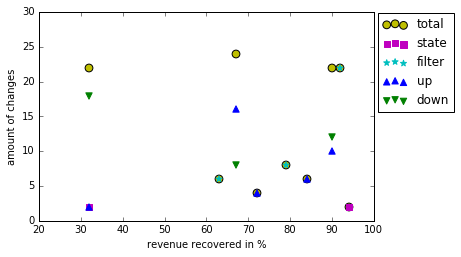

In [24]:
%matplotlib inline  
-

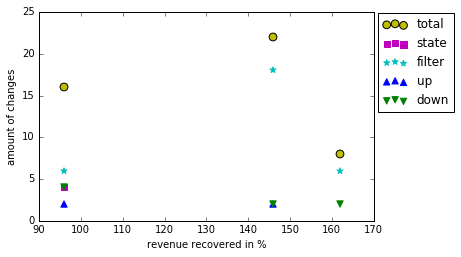

In [25]:
%matplotlib inline  
import matplotlib.pyplot as plt
from numpy import nan

res=res_split[2]
    
x = [r['rev'] for r in res]
y = [r['all_changes'] or nan for r in res] 
y1 = [r['state_changes'] or nan for r in res] 
y2 = [r['filter_changes'] or nan for r in res] 
y3 = [r['rateup_changes'] or nan for r in res] 
y4 = [r['ratedown_changes'] or nan for r in res]
size =[(30+2*(10-r['rank'])**3) for r in res]

size = 60
colors = list("rgbcmyk")
colors.pop()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_xlabel('revenue recovered in %')
ax.set_ylabel('amount of changes')
plt.scatter(x, y, c=colors.pop(), s=size, marker='o')
plt.scatter(x,y1 ,color=colors.pop(), s=40, marker='s' )
plt.scatter(x,y2,color=colors.pop(), s=40, marker='*' )
plt.scatter(x,y3,color=colors.pop(), s=40, marker='^')
plt.scatter(x,y4,color=colors.pop(), s=40, marker='v')
keys = ["all_changes", "state_changes", "filter_changes", "rateup_changes", "ratedown_changes"]    
plt.legend(['total','state','filter', 'up', 'down'], loc=2, bbox_to_anchor=(1.01,1) , borderaxespad=0.10)
#plt.ylim(0, 25)
#plt.xlim(0, 600)
plt.savefig("changes_rev_s2.pdf", format='pdf', transparent=True, bbox_inches = 'tight')
plt.show()